This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from cellpose import models
from skimage import io

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

## parse args and set paths

If if a notebook run the hardcoded paths.
However, if this is run as a script, the paths are set by the parsed arguments.

In [ ]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="Patient ID to use for the segmentation",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )
    parser.add_argument(
        "--twoD_method",
        type=str,
        choices=["zmax", "middle"],
        help="Method used to flatten the 3D image to 2D for segmentation",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    well_fov = args.well_fov
    patient = args.patient
    twoD_method = args.twoD_method
else:
    print("Running in a notebook")
    patient = "NF0014"
    well_fov = "C4-2"
    clip_limit = 0.01
    twoD_method = "zmax"

if twoD_method == "middle":
    input_dir = pathlib.Path(
        f"../../data/{patient}/middle_slice_illum_correction/{well_fov}"
    ).resolve(strict=True)

elif twoD_method == "zmax":
    input_dir = pathlib.Path(
        f"../../data/{patient}/zmax_proj_illum_correction/{well_fov}"
    ).resolve(strict=True)
else:
    raise ValueError(f"Unknown twoD_method: {twoD_method}")

mask_path = input_dir

Running in a notebook


## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

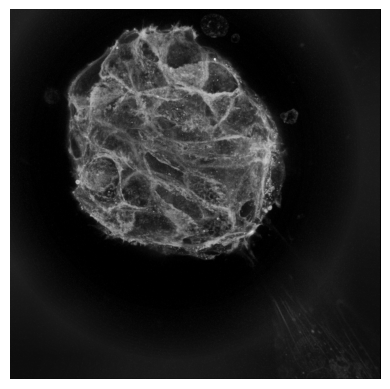

In [4]:
# get the nuclei image
for f in files:
    if "555" in f:
        cell = io.imread(f)
cell = np.array(cell)
cell = skimage.exposure.equalize_adapthist(cell, clip_limit=clip_limit)
plt.imshow(cell, cmap="gray")
plt.axis("off")
plt.show()

## Cellpose

In [5]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "cyto3"
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)


labels, details, _ = model.eval(cell, diameter=100, channels=[0, 0])

# save the labels
labels_path = input_dir / f"{well_fov}_cell_masks.tiff"
tifffile.imwrite(labels_path, labels.astype(np.uint16))

<Figure size 1000x500 with 0 Axes>

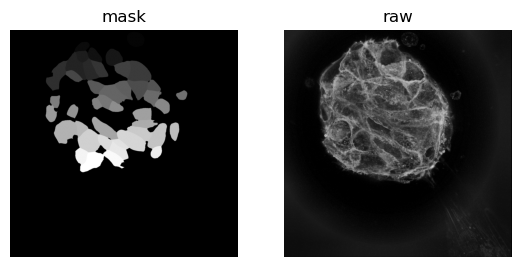

In [6]:
if in_notebook:
    plot = plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(labels, cmap="gray")
    plt.title("mask")
    plt.axis("off")

    plt.subplot(132)
    plt.imshow(cell, cmap="gray")
    plt.title("raw")
    plt.axis("off")